# 1.验证模型结构

In [ ]:
import torch
import numpy as np
from base_module import *

from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()
env.reset()


# 检测GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# 测试用输入
batch =  []
batch_size = 16
feature_channels = 35
feature_height = 4
feature_width = 9

action_space = 47

while len(batch) < batch_size:
    while not env.is_over():
        curr_pid = env.get_curr_player_id()
        valid_actions = env.get_valid_actions()
        action = np.random.choice(valid_actions)
        env.step(player_id=curr_pid, action=action)
    print(env.get_payoffs())
    for i in range(4):
        batch.append(env.get_observation_with_return(i))
    env.reset()
collator = myCollator()

In [ ]:
from base_module import *
import torch
import torch.nn as nn
import numpy as np
from transformers import GPT2Model, GPT2Config


# 检测GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
# 创建模型
config = GPT2Config(n_embd=512, n_layer=8, n_head=8, n_positions=128)
model = Policy_Network(config).to(device)
data = collator(batch)
model.eval()


In [ ]:

output = model.forward(**data)
print("action_logits:", output["action_logits"].shape)
print(output["action_logits"][0])
print("probs:", output["action_probs"][0])
# print("loss:", output["loss"])
print("action:", output["action"])


# 2.验证麻将环境

In [1]:
from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()
env.reset()

In [ ]:
print(env.get_valid_actions())
print(env.legal_actions_mask_record)

In [ ]:
while not env.is_over():
    curr_pid = env.get_curr_player_id()
    valid_actions = env.get_valid_actions()
    action = np.random.choice(valid_actions)
    env.step(player_id=curr_pid, action=action)
print(env.get_payoffs())

#### 展示当前phase和合法动作列表

In [ ]:
phase, aviable_action = env._proceed()
print("phase:", phase)
for idx, action in enumerate(aviable_action):
    print(idx, action.to_string())

valid_action = env.get_valid_actions()
print("valid_action:", valid_action)

#### 执行动作

In [4]:
env.step(2, 0)

In [ ]:
for i in range(4):
    print("player", i, "hand:", env._get_hand_tiles(i))

In [ ]:
obs = env.get_observation(1)
print("tiles_features shape:", obs['tiles_features'].shape)
print("oya shape:", obs['info']['oya'].shape)
print("riichi_sticks shape:", obs['info']['riichi_sticks'].shape)
print("action_list shape:", obs['action_list'].shape)
print("action_list:", obs['action_list'])
print("self_action_mask shape:", obs['self_action_mask'].shape)
print("self_action_mask:", obs['self_action_mask'])
print("sum self_action_mask:", obs['self_action_mask'].sum())
print("attention_mask shape:", obs['attention_mask'].shape)
print("attention_mask:", obs['attention_mask'])
print("Q shape:", obs['Q_values'].shape)
print("Q:", obs['Q_values'])
print("legal_action_mask shape:", obs['legal_action_mask'].shape)
print("legal_action_mask:", obs['legal_action_mask'])

In [ ]:
for i in range(4):
    print("player", i, "fuuros:", env._get_fuuros(i))
    print("points:", env._get_points(i))

In [ ]:
obs['info']

# 3.使用模型来决策

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch

# 使用第一个可用的 GPU，即设备 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
import torch
import numpy as np
from base_module import *

from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()
env.reset()

config = GPT2Config(n_embd=512, n_layer=8, n_head=8, n_positions=128)
model = Policy_Network(config).to(device)
model.eval()

collator = myCollator()
for i in range(100):
    while not env.is_over():
        curr_pid = env.get_curr_player_id()
        obs = env.get_observation(curr_pid)
        input = {
        "tiles_features": torch.tensor(obs['tiles_features'], dtype=torch.float32).to(device),
        "oya": torch.tensor(obs['info']['oya'], dtype=torch.float32).unsqueeze(0).to(device),
        "riichi_sticks": torch.tensor(obs['info']['riichi_sticks'],dtype=torch.float32).unsqueeze(0).to(device),
        "action_list": torch.tensor(obs['action_list'],dtype=torch.long).unsqueeze(0).to(device),
        "attention_mask": torch.tensor(obs['attention_mask'],dtype=torch.long).unsqueeze(0).to(device),
        "legal_action_mask": torch.tensor(obs['legal_action_mask'], dtype=bool).to(device)
        }
        output = model.inference(**input)
        action = output["action"].item()
        env.step(player_id=curr_pid, action_idx=action)
        # print("player:", curr_pid, "action:", action)
    print(env.get_payoffs())
    env.reset()



# print("action:", output["action"])

# 4. 开始训练

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
import torch

# 使用第一个可用的 GPU，即设备 1
inference_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
training_device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print("inference_device:", inference_device)
print("training_device:", training_device)

import numpy as np
from base_module import *

from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()
env.reset()

config = GPT2Config(n_embd=512, n_layer=8, n_head=8, n_positions=128)
inference_model = Policy_Network(config).to(inference_device)
inference_model.eval()

training_model = Policy_Network(config).to(training_device)
training_model.load_state_dict(inference_model.state_dict())
training_model.train()

collator = myCollator(device=training_device)
inference_collator = inference_Collator(device=inference_device)
optimizer = torch.optim.Adam(training_model.parameters(), lr=1e-6)
# 工厂函数
def make_env():
    env = myMahjongEnv()
    return env

inference_device: cuda:0
training_device: cuda:1


/data/satori_hdd4/Ren/envs/RL_uzumaki/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
from tqdm import tqdm
import random

epochs = 1
num_envs = 1
num_games = 10
train_epochs = 1
batch_size = 4

# 创建vector环境
env = gym.vector.AsyncVectorEnv([make_env for _ in range(num_envs)])
obs, info = env.reset()
done = np.array([False for _ in range(num_envs)])

for epoch in tqdm(range(epochs)): 
   # 生成num_games局对局数据
    dataset = []
    while len(dataset) < num_games*4:
        input = inference_collator(obs)
        with torch.no_grad():
            output = inference_model.inference(**input)
        prob = output["action_probs"].cpu().numpy()
        # prob的形状为(num_envs, 47)
        actions = np.array([np.random.choice(47, p=prob[i]) for i in range(num_envs)])
        try:
            obs, reward, done, _, info = env.step(actions)
        except IndexError as e:
            print(e)
            # 重置环境
            env.step_wait()
            obs, info = env.close()
            env = gym.vector.AsyncVectorEnv([make_env for _ in range(num_envs)])
            obs, info = env.reset()
            done = np.array([False for _ in range(num_envs)])
            continue

        if 'final_info' in info:
            for i in range(num_envs):
                if info['final_info'][i] is not None:
                    # if info['final_info'][i]['payoffs'].any():
                    dataset.extend(info['final_info'][i]['obs_with_return'])

    # 从dataset中每次取出batch_size个数据进行训练
    for train_epoch in tqdm(range(train_epochs)):
        # 打乱数据
        random.shuffle(dataset)
        for batch_idx in range(0, len(dataset), batch_size):
            batch = dataset[batch_idx:batch_idx+batch_size]
            data = collator(batch)
            # 移动数据到training_device
            for key in data.keys():
                if key == "info":
                    for sub_key in data[key].keys():
                        data[key][sub_key] = data[key][sub_key].to(training_device)
                else:
                    data[key] = data[key].to(training_device)
            optimizer.zero_grad()
            output = training_model.forward(**data)
            loss = output["loss"]
            loss.backward()
            optimizer.step()
            print("loss:", loss.item())

    # 将training_model的参数复制到inference_model,并保存checkpoint
    inference_model.load_state_dict(training_model.state_dict())
    # torch.save(inference_model.state_dict(), f"./checkpoints/epoch_{epoch}.pth")






  0%|          | 0/1 [00:00<?, ?it/s]

loss: -0.0
loss: -0.0
loss: -102.61990356445312
loss: -247.82321166992188
loss: -0.0
loss: -0.0
loss: 225.94436645507812


100%|██████████| 1/1 [00:21<00:00, 21.78s/it]

loss: -0.0
loss: -208.520263671875
loss: 194.16737365722656


In [ ]:
len(dataset)

### 4.1 检查模型效果

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch

# 使用第一个可用的 GPU，即设备 1
inference_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# training_device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print("inference_device:", inference_device)
# print("training_device:", training_device)

import numpy as np
from base_module import *

from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()
obs, info = env.reset()

config = GPT2Config(n_embd=512, n_layer=8, n_head=8, n_positions=128)
inference_model = Policy_Network(config).to(inference_device)
inference_collator = inference_Collator(device=inference_device)

inference_model.load_state_dict(torch.load("./checkpoints/epoch_13.pth", weights_only=True))
inference_model.eval()

action_represenation = {
    0: 'dicard 1m',
    1: 'dicard 2m',
    2: 'dicard 3m',
    3: 'dicard 4m',
    4: 'dicard 5m',
    5: 'dicard 6m',
    6: 'dicard 7m',
    7: 'dicard 8m',
    8: 'dicard 9m',
    9: 'dicard 1p',
    10: 'dicard 2p',
    11: 'dicard 3p',
    12: 'dicard 4p',
    13: 'dicard 5p',
    14: 'dicard 6p',
    15: 'dicard 7p',
    16: 'dicard 8p',
    17: 'dicard 9p',
    18: 'dicard 1s',
    19: 'dicard 2s',
    20: 'dicard 3s',
    21: 'dicard 4s',
    22: 'dicard 5s',
    23: 'dicard 6s',
    24: 'dicard 7s',
    25: 'dicard 8s',
    26: 'dicard 9s',
    27: 'dicard east',
    28: 'dicard south',
    29: 'dicard west',
    30: 'dicard north',
    31: 'dicard white',
    32: 'dicard green',
    33: 'dicard red',
    34: 'chi_left',
    35: 'chi_middle',
    36: 'chi_right',
    37: 'pon',
    38: 'ankan',
    39: 'minkan',
    40: 'kakan',
    41: 'riichi',
    42: 'ron',
    43: 'tsumo',
    44: 'kyushukyuhai',
    45: 'pass_naki',
    46: 'pass_riichi'
}

inference_device: cuda:0


/data/satori_hdd4/Ren/envs/RL_uzumaki/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
obs, info = env.reset()

Pt: 25000
Wind: South
Hand: 2m 4m 5m 6m 6p 1s 2s 4s 0s 7s 7s 8s 3z 6z 
River: 9p2h 9m6h- 
Riichi: No
Menzen: Yes
model selected action: dicard 4s


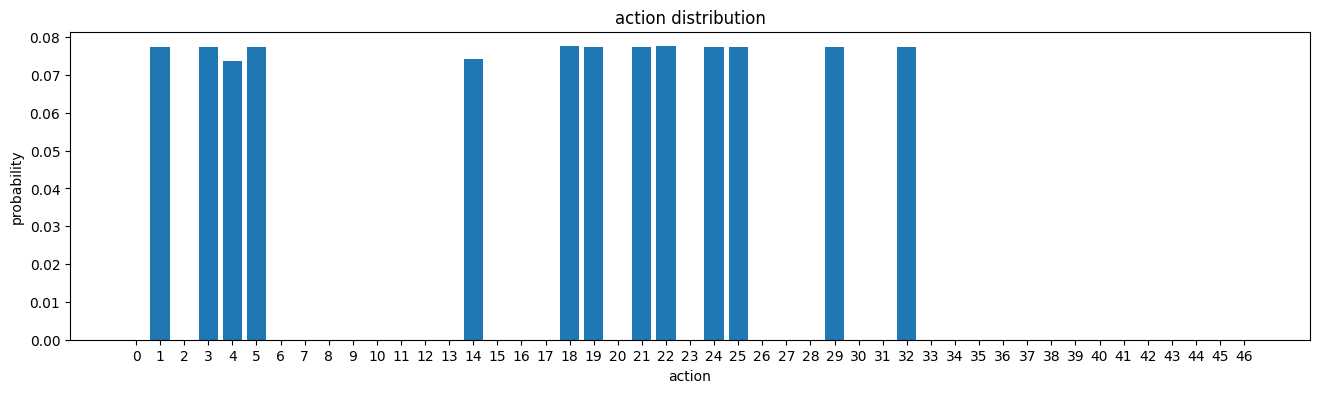

In [19]:
import matplotlib.pyplot as plt

curr_pid = env.get_curr_player_id()


input = inference_collator(obs)
with torch.no_grad():
    output = inference_model.inference(**input)
probs = output["action_probs"].cpu().numpy()
action = np.random.choice(47, p=probs[0])


curr_pid = env.get_curr_player_id()
print(env.t.players[curr_pid].to_string())
print("model selected action:", action_represenation[action])

obs, r, done, _, info = env.step(action)
# 绘制动作概率分布
plt.figure(figsize=(16, 4))
plt.bar(range(47), probs[0])
plt.xticks(np.arange(0, 47, 1))

plt.xlabel("action")
plt.ylabel("probability")
plt.title("action distribution")
plt.show()



In [20]:
print(env.t.to_string())

Yama: 7m 1m 5z 2p 8p 1m 6s 6s 2s 4p 5p 1z 8m 9s (Wanpai)| 8p 2m 3p 9p 3m 5m 3s 4z 3s 4p 2z 7s 8m 9m 4m 4s 0p 4s 1s 9s 4p 2s 7m 5z 3p 5p 1p 8p 3s 5m 9p 2p 1p 4p 3p 7p 8m 2z 1m 3z 6m 2m 1s 3p 8s 6p 0m 8p 6s 6z 2p 7p 6p 2m 5p 8s 7p 9m 4z 5z 7p 
Dora Indicator(s):1m 
Remaining tiles: 61
Player 0: 
Pt: 25000
Wind: South
Hand: 2m 4m 5m 6m 6p 1s 2s 0s 7s 7s 8s 3z 6z 
River: 9p2h 9m6h- 4s10h 
Riichi: No
Menzen: Yes
Player 1: 
Pt: 25000
Wind: West
Hand: 4m 6m 7m 5s 6s 9s 1z 7z 7z 7z 
Calls: 7m8m(9m) 
River: 6p3h 3m7h 
Riichi: No
Menzen: No
Player 2: 
Pt: 25000
Wind: North
Hand: 1m 3m 4m 1p 2p 9p 3s 4s 8s 1z 3z 4z 5z 
River: 5s4h 6z8h 
Riichi: No
Menzen: Yes
Player 3: 
Pt: 25000
Wind: East
Hand: 3m 6m 9m 1p 5s 7s 9s 1z 2z 2z 4z 6z 7z 
River: 3z1h 2s5h 1s9h 
Riichi: No
Menzen: Yes

Oya player 3
Honba: 0
Kyoutaku: 0



# 5.检查环境bug

In [ ]:
import numpy as np
from base_module import *

from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()

flag = True
# for i in range(1):
while flag:
    env.reset()
    while not env.is_over():
        curr_pid = env.get_curr_player_id()
        phase = env.t.get_phase()
        if phase < 4:
            aviable_action = env.t.get_self_actions()
        elif phase < 16:
            aviable_action = env.t.get_response_actions()


        ls = []
        for action in aviable_action:
            ls.append(action.action.name)
        set_ls = set(ls)
        if "Riichi" in set_ls:
            flag = False
            print("phase:", phase)
            print("aviable_action:", set_ls)
            break

        valid_actions = env.get_valid_actions()
        action = np.random.choice(valid_actions)
        env.step(player_id=curr_pid, action_idx=action)

    # for i in range(4):
    #     obs = env.get_observation_with_return(i)
    #     print("---------------------------""player:", i, "---------------------------")
    #     print(obs)






In [ ]:
import numpy as np
from base_module import *

from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()
env.reset()

In [ ]:
print("phase:", env.t.get_phase())
print("curr_pid:", env.get_curr_player_id())
phase = env.t.get_phase()
if phase < 4:
    aviable_action = env.t.get_self_actions()
elif phase < 16:
    aviable_action = env.t.get_response_actions()
print("aviable_action:")
ls = []
for idx, action in enumerate(aviable_action):
    ls.append(action.to_string())
    print(idx, action.to_string())
    # print(action.action.name)

print("aviable_action:", ls)

In [ ]:
env.get_valid_actions()

In [39]:
env.step(env.get_curr_player_id(), 29)

In [ ]:
print(env.riichi_stage2)
print(env.pass_riichi)

In [ ]:
env.action_record

In [ ]:
print(env.t.to_string())

### 5.1 手操检查

In [ ]:
env.t.make_selection(7)
phase = env.t.get_phase()
if phase < 4:
    aviable_action = env.t.get_self_actions()
elif phase < 16:
    aviable_action = env.t.get_response_actions()
print("after phase:", phase)
print("after aviable_action:")
for idx, action in enumerate(aviable_action):
    print(idx, action.to_string())


In [ ]:
env.t.make_selection(0)
phase = env.t.get_phase()
if phase < 4:
    aviable_action = env.t.get_self_actions()
elif phase < 16:
    aviable_action = env.t.get_response_actions()
print("after phase:", phase)
print("after aviable_action:")
for idx, action in enumerate(aviable_action):
    print(idx, action.to_string())

# 6. 数据增强验证

In [1]:
import numpy as np
from base_module import *

from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()
obs, info = env.reset()
while not env.is_over():
    valid_actions = env.get_valid_actions()
    action = np.random.choice(valid_actions)
    obs, r, done, _, info = env.step(action_idx=action)


In [ ]:
torch.tensor([obs['tiles_features']])

In [ ]:
action_list = info['obs_with_return'][0]['action_list']
attention_mask = info['obs_with_return'][0]['attention_mask']

collator = myCollator()
augmented_tiles = collator.aug_tiles_features(torch.tensor([obs['tiles_features']]))
print("augmented_tiles shape:", augmented_tiles.shape)
print(augmented_tiles[2][0])
print("--------------------")
print(obs['tiles_features'][0])

## 找到九种九牌的对局

In [1]:
import numpy as np
from base_module import *

from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()
obs, info = env.reset()
over = False
while True:
    valid_actions = env.get_valid_actions()
    if 44 in valid_actions:
        obs, r, done, _, info = env.step(action_idx=44)
        break
    else:
        obs, info = env.reset()


/data/satori_hdd4/Ren/envs/RL_uzumaki/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
info['obs_with_return'][1]['legal_action_mask']

array([], dtype=float64)

In [4]:
collator = myCollator()
data = collator(info['obs_with_return'])